<a href="https://colab.research.google.com/github/ayush403102/Lungs_disease_prediction_models/blob/main/Minor_project_ii_resnet152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#How to load the data

In [ ]:

import cv2
import os
import random
import matplotlib.pylab as plt
from glob import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


#Prepare file directories and image paths and load labels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Set path to the sample folder
PATH = "/content/drive/My Drive/sample"

# Set path to the images folder
SOURCE_IMAGES = os.path.join(PATH, "images")

# Load images
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

# Set path to the labels file
LABELS_FILE = os.path.join(PATH, "sample_labels.csv")

# Load labels
labels = pd.read_csv(LABELS_FILE)


In [ ]:
# First five images paths
images[0:5]

['/content/drive/My Drive/sample/images/00023097_001.png',
 '/content/drive/My Drive/sample/images/00023033_002.png',
 '/content/drive/My Drive/sample/images/00022884_000.png',
 '/content/drive/My Drive/sample/images/00022947_001.png',
 '/content/drive/My Drive/sample/images/00022963_000.png']

#Show three random image

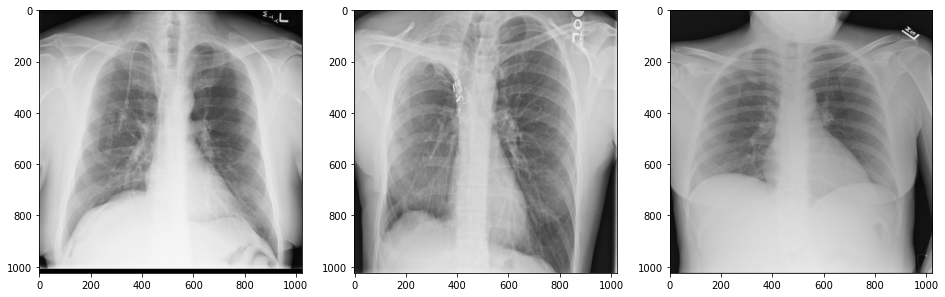

In [ ]:
if len(images) >= 3:
    r = random.sample(images, 3)

    # Matplotlib black magic
    plt.figure(figsize=(16,16))
    plt.subplot(131)

    plt.imshow(cv2.imread(r[0]))

    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))

    plt.subplot(133)
    plt.imshow(cv2.imread(r[2]))
else:
    print("Error: images list contains less than 3 elements.")

/content/drive/My Drive/sample/images/00030209_008.png


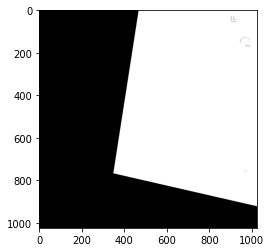

In [ ]:
# Print out image file path
image_path =  os.path.join(SOURCE_IMAGES, '00030209_008.png')
print(image_path)

# Load image data
image_data = cv2.imread(image_path)

# Convert image data to a different data type
image_data = image_data.astype('float32')

# Display image
plt.imshow(image_data)

#Turn images into arrays and make a list of classes

In [ ]:
def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    
    disease="Infiltration"

    x = [] # images as arrays
    y = [] # labels Infiltration or Not_infiltration
    WIDTH = 128
    HEIGHT = 128

    for img in images:
        base = os.path.basename(img)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]

        # Read and resize image
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))

        # Labels
        if disease in finding:
            #finding = str(disease)
            finding = 1
            y.append(finding)

        else:
            #finding = "Not_" + str(disease)
            finding = 0
            y.append(finding)

    return x,y

In [ ]:
x,y = proc_images()

In [ ]:
# Set it up as a dataframe if you like
df = pd.DataFrame()
df["labels"]=y
df["images"]=x

In [ ]:
print(len(df), df.images[0].shape)

5606 (128, 128, 3)


#Saving arrays for use in another kernel

In [ ]:
np.savez("x_images_arrays", x)
np.savez("y_infiltration_labels", y)

In [ ]:
!ls -1

drive
sample_data
x_images_arrays.npz
y_infiltration_labels.npz


In [ ]:
import datetime as dt
import pandas as pd
import numpy as np
start = dt.datetime.now()

In [ ]:
# Load npz file containing image arrays
x_npz = np.load("/content/x_images_arrays.npz")
x = x_npz['arr_0']

# Load binary encoded labels for Lung Infiltrations: 0=Not_infiltration 1=Infiltration
y_npz = np.load("/content/y_infiltration_labels.npz")
y = y_npz['arr_0']

In [ ]:
from sklearn.model_selection import train_test_split

# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

# Second split the 20% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)

In [ ]:
print(np.array(X_train).shape)
print(np.array(X_val).shape)
print(np.array(X_test).shape)

(4484, 128, 128, 3)
(561, 128, 128, 3)
(561, 128, 128, 3)


In [ ]:
# Import the ResNet50 network architecture
from keras.applications import ResNet152

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_DEPTH = 3
BATCH_SIZE = 16

# Instantiate the model with the pre-trained weights (no top)
conv_base = ResNet152(weights='imagenet',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))

# Show the architecture
conv_base.summary()

234698864/234698864 [==============================] - 2s 0us/step
Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormali

In [ ]:
# Extract features
train_features = conv_base.predict(np.array(X_train), batch_size=BATCH_SIZE, verbose=1)
test_features = conv_base.predict(np.array(X_test), batch_size=BATCH_SIZE, verbose=1)
val_features = conv_base.predict(np.array(X_val), batch_size=BATCH_SIZE, verbose=1)

36/36 [==============================] - 96s 3s/step


In [ ]:
# Save extracted features
np.savez("train_features", train_features, y_train)
np.savez("test_features", test_features, y_test)
np.savez("val_features", val_features, y_val)

In [ ]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(4484, 4, 4, 2048) 
 (561, 4, 4, 2048) 
 (561, 4, 4, 2048)


In [ ]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (4484, -1))
test_features_flat = np.reshape(test_features, (561, -1))
val_features_flat = np.reshape(val_features, (561, -1))

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks

In [ ]:
# Define the densely connected classifier
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 50

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(32768)))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Train the the model
history = model.fit(
    train_features_flat,
    y_train,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, y_val),
    callbacks=callbacks
)

Epoch 1/50
141/141 [==============================] - 44s 301ms/step - loss: 0.7554 - acc: 0.7645 - val_loss: 0.6944 - val_acc: 0.8253 - lr: 2.0000e-05
Epoch 2/50
141/141 [==============================] - 42s 295ms/step - loss: 0.4157 - acc: 0.8316 - val_loss: 0.5815 - val_acc: 0.8039 - lr: 2.0000e-05
Epoch 3/50
141/141 [==============================] - 48s 343ms/step - loss: 0.2665 - acc: 0.8981 - val_loss: 0.5801 - val_acc: 0.7415 - lr: 2.0000e-05
Epoch 4/50
141/141 [==============================] - 45s 320ms/step - loss: 0.1847 - acc: 0.9302 - val_loss: 0.7334 - val_acc: 0.6684 - lr: 2.0000e-05
Epoch 5/50
141/141 [==============================] - ETA: 0s - loss: 0.1258 - acc: 0.9599
Epoch 5: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
141/141 [==============================] - 45s 317ms/step - loss: 0.1258 - acc: 0.9599 - val_loss: 0.6145 - val_acc: 0.7932 - lr: 2.0000e-05
Epoch 6/50
141/141 [==============================] - 44s 310ms/step - loss: 0.0439 

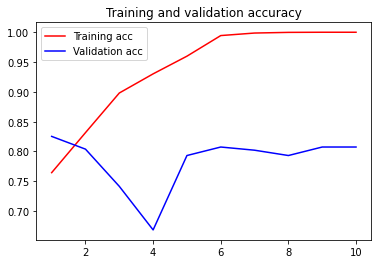

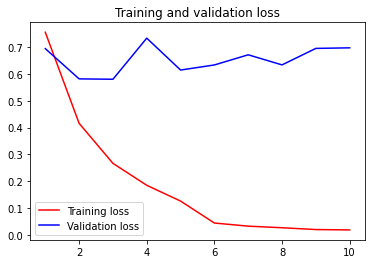

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

##Be mindful of your run-time
Most of this kernel's compute time was spent extracting the features. Save your features when you extract them and import them into another kernel so that you have more time for training on your new dataset.



In [ ]:
# Run time
end = dt.datetime.now()
print("Run time:", (end - start).seconds, 'seconds')

Run time: 1522 seconds
